In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Load Processed Data (data engineering; 24h; aggregation)

In [2]:
df_agg = pd.read_csv('../../data/mimic_dataset_24h_aggregated.csv')

## 2. Define X and y

In [3]:
target_col = 'died_in_hosp'
y = df_agg[target_col].astype(int)
X = df_agg.drop(columns=[target_col])
print(f'mortality rate: {y.mean():.4f}')

mortality rate: 0.1646


## 3. Data Splitting

- Divide the dataset into the training set and the test set, with an 80/20 ratio.
- To ensure that the proportion of deceased/survived patients in the training set and the test set is consistent with the original data, `stratified sampling` is adopted.

In [4]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=42, 
    stratify=y
)

print(f"Size of the training set: {X_train.shape}")
print(f"Size of the testing set: {X_test.shape}")
print(f"Training set mortality rate: {y_train.mean():.3f}")
print(f"Testing set mortality rate: {y_test.mean():.3f}")

Size of the training set: (23248, 325)
Size of the testing set: (5812, 325)
Training set mortality rate: 0.165
Testing set mortality rate: 0.165


## 4. Missing Value Imputation

- For numerical features, using the median is often more robust than the mean, as it is not affected by outliers. For categorical features, the mode can be used. 
    
- The imputation values are calculated only on the training set and then applied to both the training and testing sets to prevent data leakage.

In [5]:
print(f"Proportion of missing values:")
missing_proportion = (X.isnull().sum()/X.shape[0]).sort_values(ascending=False) 
print(missing_proportion)

Proportion of missing values:
ETCO2_std          0.087027
ETCO2_mean         0.056435
ETCO2_min          0.056435
ETCO2_max          0.056435
ETCO2_last         0.056435
                     ...   
Potassium_max      0.000000
Potassium_min      0.000000
Potassium_mean     0.000000
PAWplateau_last    0.000000
SIRS_last          0.000000
Length: 325, dtype: float64


In [6]:
imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

## 5. Feature Scaling

- Logistic regression models are highly sensitive to the scale of features. Different features (e.g., age and creatinine) can have vastly different value ranges, which can affect the model's convergence speed and performance.  
  
- We need to standardize the features using **StandardScaler**, which scales all features to have a mean of 0 and a variance of 1.  
  
- `StandardScaler` should be fit only on the training set and then used to transform both the training and testing sets. This means the mean and variance are calculated from the training set, and the same scaling is applied to both the training and testing sets.  

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
print('X train after scaling:')
print(X_train_scaled)
print('X test after scaling:')
print(X_test_scaled)

X train after scaling:
[[ 0.89493804  1.18677072  0.01443548 ... -1.39132593 -0.15672227
  -0.55506599]
 [-1.1173958   0.45489882  0.44140258 ...  0.74559775  0.36255966
   0.43695232]
 [-1.1173958  -1.31379158 -0.41253161 ...  0.74559775 -0.11265371
   0.43695232]
 ...
 [ 0.89493804 -0.03301577 -1.2664658  ...  0.74559775  0.68549439
   1.42897063]
 [-1.1173958  -1.00884496 -1.2664658  ... -0.32286409  1.06254431
  -1.5470843 ]
 [ 0.89493804  0.21094153 -0.83949871 ... -0.32286409 -0.15672227
  -0.55506599]]
X test after scaling:
[[ 0.89493804 -2.28962077 -1.6934329  ... -0.32286409  1.3168207
   0.43695232]
 [ 0.89493804  1.18677072  0.01443548 ...  1.81405959 -0.27197589
   1.42897063]
 [ 0.89493804  0.27193085 -0.41253161 ... -2.45978778 -0.15672227
  -1.5470843 ]
 ...
 [ 0.89493804  0.75984545  2.14927096 ... -1.39132593 -0.3122048
  -0.55506599]
 [-1.1173958  -0.21598374  0.44140258 ... -0.32286409 -0.3122048
  -0.55506599]
 [ 0.89493804 -0.27697307  0.86836968 ... -1.39132593 -1

## 6. L1 regularized logistic regression

### 6.1  initialize model

In [ ]:
l1_model = LogisticRegression(
    penalty='l1',             # L1 regularization
    solver='liblinear',    
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    max_iter=1000
)

### 6.2 Define the search range for the hyperparameter C

In [9]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]
}


### 6.3 Grid search and cross-validation

In [16]:
grid_search = GridSearchCV(
    estimator=l1_model,
    param_grid=param_grid,
    cv=5,                    # 5-fold cross-validation
    scoring= 'average_precision',   # Use AUCPRC as the evaluation metric
    n_jobs=-1,               
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, penalty='l1',
                                          random_state=42, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50,
                               100]},
             scoring='average_precision', verbose=1)

### 6.4 best model

In [17]:
print(grid_search.best_estimator_)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')


In [20]:
best_model = grid_search.best_estimator_
best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f"\nOptimal hyperparameters C: {best_C}")
print(f"Optimal cross-validation AUCPRC: {best_score:.4f}")

print("\nAll the cross-validation results of the C values:")
results_df = pd.DataFrame(grid_search.cv_results_)
for c_val, mean_score, std_score in zip(
    results_df['param_C'], 
    results_df['mean_test_score'], 
    results_df['std_test_score']
):
    print(f"  C={c_val:8.4f}: AUCPRC={mean_score:.4f} (±{std_score:.4f})")



Optimal hyperparameters C: 0.01
Optimal cross-validation AUCPRC: 0.5578

All the cross-validation results of the C values:
  C=  0.0001: AUCPRC=0.1646 (±0.0001)
  C=  0.0010: AUCPRC=0.5059 (±0.0241)
  C=  0.0100: AUCPRC=0.5578 (±0.0264)
  C=  0.1000: AUCPRC=0.5572 (±0.0224)
  C=  0.5000: AUCPRC=0.5539 (±0.0216)
  C=  1.0000: AUCPRC=0.5532 (±0.0223)
  C=  5.0000: AUCPRC=0.5490 (±0.0230)
  C= 10.0000: AUCPRC=0.5499 (±0.0240)
  C= 50.0000: AUCPRC=0.5501 (±0.0236)
  C=100.0000: AUCPRC=0.5501 (±0.0234)


## 7. Model Evaluation

In [21]:
# predict
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)
y_train_proba = best_model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Training set performance
print("Training set performance:")
print(f"    - Accuracy rate: {best_model.score(X_train_scaled, y_train):.4f}")
print(f"    - AUROC: {roc_auc_score(y_train, y_train_proba):.4f}")
print(f"    - AUPRC: {average_precision_score(y_train, y_train_proba):.4f}")

# Testing set performance
print("\nTesting set performance:")
print(f"    - Accuracy rate: {best_model.score(X_test_scaled, y_test):.4f}")
print(f"    - AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"    - AUPRC: {average_precision_score(y_test, y_test_proba):.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, 
                          target_names=['survival', 'death']))

Training set performance:
    - Accuracy rate: 0.7774
    - AUROC: 0.8444
    - AUPRC: 0.5670

Testing set performance:
    - Accuracy rate: 0.7860
    - AUC: 0.8497
    - AUPRC: 0.5809

Classification Report (Test Set):
              precision    recall  f1-score   support

    survival       0.94      0.80      0.86      4855
       death       0.42      0.74      0.53       957

    accuracy                           0.79      5812
   macro avg       0.68      0.77      0.70      5812
weighted avg       0.85      0.79      0.81      5812



In [22]:

print("\nConfusion matrix (test set)")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
print(f"  True Negative (TN): {cm[0,0]}, False Positive (FP): {cm[0,1]}")
print(f"  False Negative (FN): {cm[1,0]}, True Positive (TP): {cm[1,1]}")




Confusion matrix (test set)
[[3860  995]
 [ 249  708]]
  True Negative (TN): 3860, False Positive (FP): 995
  False Negative (FN): 249, True Positive (TP): 708


## 8. Feature Analysis - L1 Automatic Feature Selection

In [ ]:
coefficients = best_model.coef_[0]

feature_names = X.columns.tolist()
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})


selected_features = feature_importance[feature_importance['coefficient'] != 0]
zero_features = feature_importance[feature_importance['coefficient'] == 0]

print(f"\nThe result of L1 regularization feature selection:")
print(f"  total number of features: {len(feature_names)}")
print(f"  number of selected features: {len(selected_features)}")
print(f"  number of removed features: {len(zero_features)}")
print(f"  feature selection rate: {len(selected_features)/len(feature_names)*100:.1f}%")

# 3. Analyzing Importance - Sorted by Absolute Value
selected_features_sorted = selected_features.sort_values(
    'abs_coefficient', ascending=False
)

print(f"\nTop 20 most important characteristics (sorted by the absolute value of the coefficients):")
for i, row in selected_features_sorted.head(20).iterrows():
    direction = "↑ increase" if row['coefficient'] > 0 else "↓ decrease"
    print(f"{row['feature']:30s}: {row['coefficient']:8.4f} ({direction} mortality risk)")



The result of L1 regularization feature selection:
  total number of features: 325
  number of selected features: 85
  number of removed features: 240
  feature selection rate: 26.2%

Top 20 most important characteristics (sorted by the absolute value of the coefficients):
age                           :   0.3595 (↑ increasemortality risk)
elixhauser                    :   0.2487 (↑ increasemortality risk)
extubated_mean                :  -0.2116 (↓ decreasemortality risk)
output_step_mean              :  -0.2069 (↓ decreasemortality risk)
GCS_max                       :  -0.2004 (↓ decreasemortality risk)
GCS_last                      :  -0.1880 (↓ decreasemortality risk)
SpO2_last                     :  -0.1769 (↓ decreasemortality risk)
Weight_kg                     :  -0.1744 (↓ decreasemortality risk)
SOFA_last                     :   0.1698 (↑ increasemortality risk)
Shock_Index_last              :   0.1615 (↑ increasemortality risk)
median_dose_vaso_last         :   0.1520 (↑ i

## 9. Results Visualization

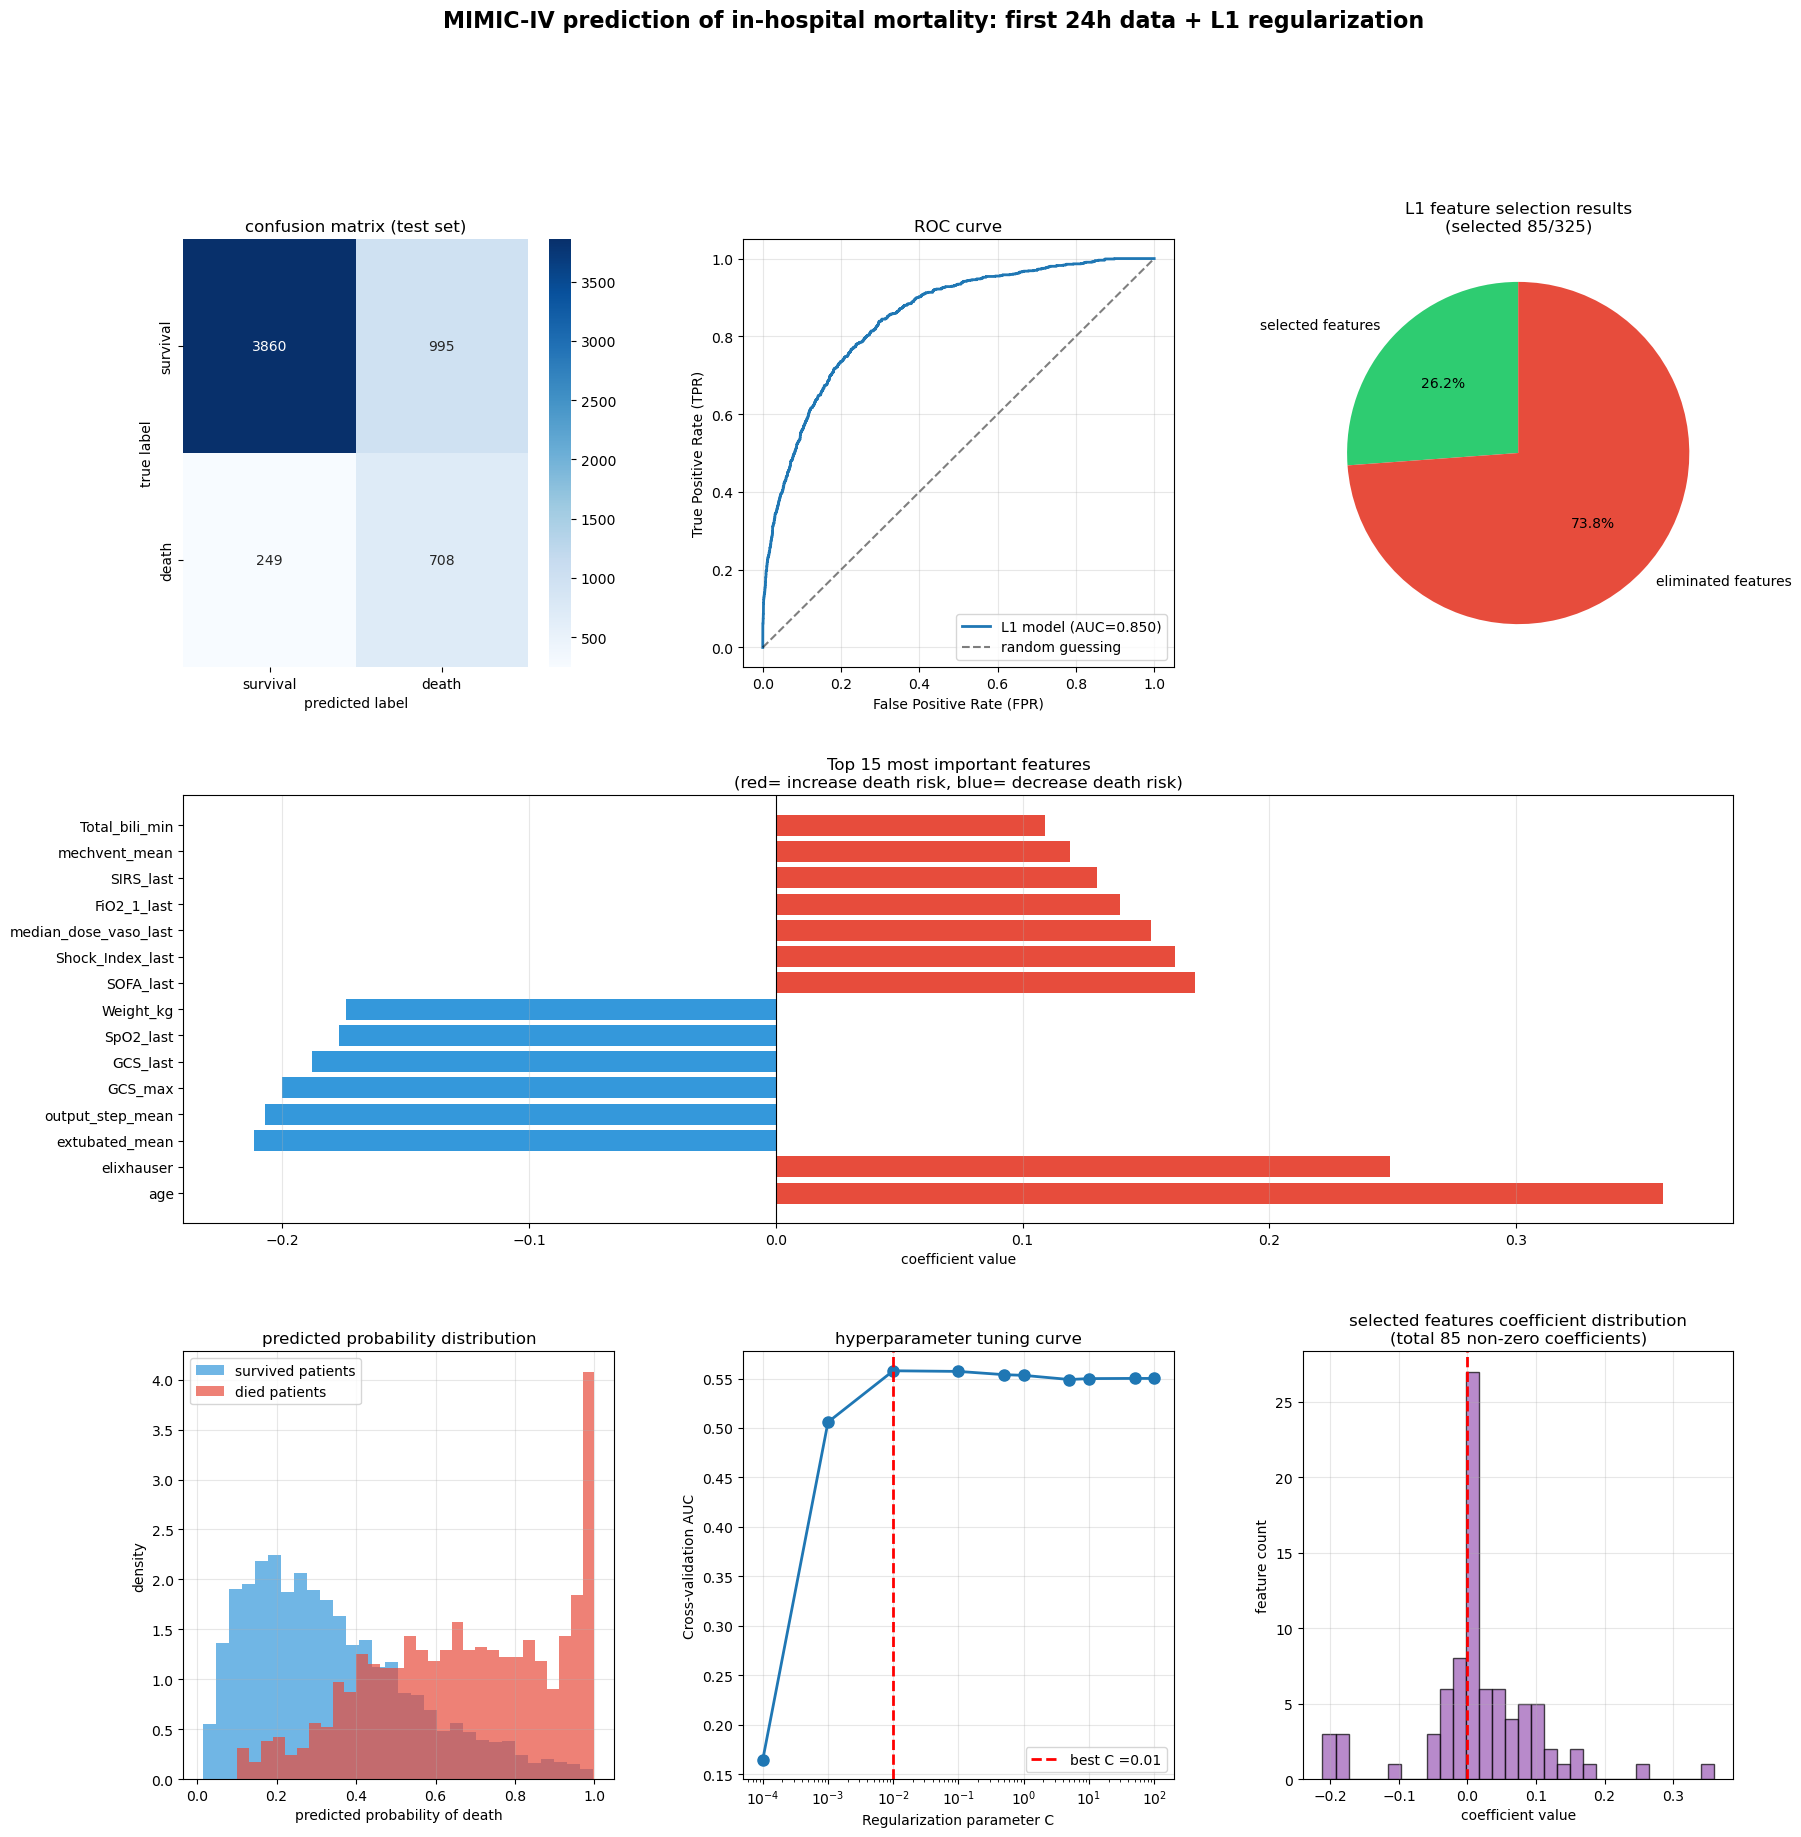

In [24]:
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. confusion matrix
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['survival', 'death'], 
            yticklabels=['survival', 'death'])
ax1.set_title('confusion matrix (test set)')
ax1.set_xlabel('predicted label')
ax1.set_ylabel('true label')

# 2. ROC curve
test_auc = roc_auc_score(y_test, y_test_proba)
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
ax2.plot(fpr, tpr, label=f'L1 model (AUC={test_auc:.3f})', linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', label='random guessing', alpha=0.5)
ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_title('ROC curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. feature selection statistics
ax3 = fig.add_subplot(gs[0, 2])
selection_stats = [len(selected_features), len(zero_features)]
ax3.pie(selection_stats, labels=['selected features', 'eliminated features'],
        autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
ax3.set_title(f'L1 feature selection results\n(selected {len(selected_features)}/{len(feature_names)})')

# 4. Top 15 feature importance
ax4 = fig.add_subplot(gs[1, :])
top15 = selected_features_sorted.head(15)
colors = ['#e74c3c' if x > 0 else '#3498db' for x in top15['coefficient']]
ax4.barh(range(len(top15)), top15['coefficient'], color=colors)
ax4.set_yticks(range(len(top15)))
ax4.set_yticklabels(top15['feature'])
ax4.set_xlabel('coefficient value')
ax4.set_title('Top 15 most important features\n(red= increase death risk, blue= decrease death risk)')
ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax4.grid(True, axis='x', alpha=0.3)

# 5. predicted probability distribution
ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(y_test_proba[y_test==0], bins=30, alpha=0.7, 
         label='survived patients', density=True, color='#3498db')
ax5.hist(y_test_proba[y_test==1], bins=30, alpha=0.7, 
         label='died patients', density=True, color='#e74c3c')
ax5.set_xlabel('predicted probability of death')
ax5.set_ylabel('density')
ax5.set_title('predicted probability distribution')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Regularization path - The influence of C value on the number of features
ax6 = fig.add_subplot(gs[2, 1])
c_values = param_grid['C']
auc_scores = results_df['mean_test_score'].values
ax6.plot(c_values, auc_scores, 'o-', linewidth=2, markersize=8)
ax6.axvline(x=best_C, color='red', linestyle='--', 
            label=f'best C ={best_C}', linewidth=2)
ax6.set_xscale('log')
ax6.set_xlabel('Regularization parameter C')
ax6.set_ylabel('Cross-validation AUC')
ax6.set_title('hyperparameter tuning curve')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. coefficient distribution of selected features
ax7 = fig.add_subplot(gs[2, 2])
ax7.hist(selected_features['coefficient'], bins=30, 
         color='#9b59b6', alpha=0.7, edgecolor='black')
ax7.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax7.set_xlabel('coefficient value')
ax7.set_ylabel('feature count')
ax7.set_title(f'selected features coefficient distribution\n(total {len(selected_features)} non-zero coefficients)')
ax7.grid(True, alpha=0.3)

plt.suptitle('MIMIC-IV prediction of in-hospital mortality: first 24h data + L1 regularization', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()
